In [1]:
#Load libraries 
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from urllib.parse import urlparse

In [13]:
#Load data 

df = pd.read_csv('/Users/chigozirimibeabuchi/Downloads/Ipsos.csv')

# Identify rows with missing values
gender_df = df[df['gender_char'].isna()]
gender_df.to_csv('gender_na.csv', index=False)


#check for missing values
missing_values = df.isnull().sum()
df = df.dropna()
print(df.shape)
df

(26540984, 10)


,Unnamed: 0,panelist_id,OS,gender_char,age_group_char,social_grade_char,Date,Time,PageDomain,PageUrl
0,1,1.836572e+18,Android 11,female,25-34,c2,2022-12-01,18:08:22,tester.userbrain.net,tester.userbrain.net/dashboard
1,2,1.836572e+18,Android 11,female,25-34,c2,2022-12-01,13:10:03,google.com,google.com
2,3,-7.206297e+18,Windows 10,female,45-54,ab,2022-12-01,11:39:38,outlook.live.com,outlook.live.com/mail/0/id/aqmkadawaty3zmyazs1...
3,4,-7.206297e+18,Windows 10,female,45-54,ab,2022-12-01,12:00:38,outlook.live.com,outlook.live.com/mail/0/id/aqmkadawaty3zmyazs1...
4,5,-7.206297e+18,Windows 10,female,45-54,ab,2022-12-01,18:22:20,www.raileurope.com,raileurope.com
...,...,...,...,...,...,...,...,...,...,...
33054105,33054106,6.697399e+18,Windows 11,female,65plus,ab,2022-12-31,09:56:30,www.jacquielawson.com,jacquielawson.com/ecard/pickup/r6d60e54054be42...
33054106,33054107,6.697399e+18,Windows 11,female,65plus,ab,2022-12-30,10:43:30,www.seasaltcornwall.com,seasaltcornwall.com/checkout/onepage/success
33054107,33054108,6.697399e+18,Windows 11,female,65plus,ab,2022-12-31,09:59:33,www.smartbrief.com,smartbrief.com/servlet/encodeservlet
33054108,33054109,6.697399e+18,Windows 11,female,65plus,ab,2022-12-30,10:44:29,www.cantab.net,cantab.net/logout.php


In [3]:
#Data exploration
df.describe()
# check the data types of columns
print(df.dtypes)

# convert gender column to string
df['gender_char'] = df['gender_char'].astype(str)

# check for missing values in the gender column
print(df['gender_char'].isnull().sum())

# count the unique number of users by gender
gender_count = df.groupby('gender_char')['panelist_id'].nunique()
print(gender_count)

Unnamed: 0             int64
panelist_id          float64
OS                    object
gender_char           object
age_group_char        object
social_grade_char     object
Date                  object
Time                  object
PageDomain            object
PageUrl               object
dtype: object
0
gender_char
female    5803
male      4832
Name: panelist_id, dtype: int64


In [13]:


# group the rows of the original dataframe by panelist_id, gender_char and PageUrl
grouped_df = df.groupby(['panelist_id', 'gender_char', 'PageUrl'])

# count the number of occurrences of each unique combination of panelist_id, gender_char and PageUrl
count_df = grouped_df.size().reset_index(name='count')

# filter the new dataframe to only include rows where the count of occurrences is greater than 1
duplicates_df = count_df[count_df['count'] > 1]

# create a new dataframe with the columns panelist_id, gender_char, PageUrl, and count of occurrences
new_df = duplicates_df[['panelist_id', 'gender_char', 'PageUrl', 'count']]

# save the new dataframe to a CSV file
new_df.to_csv('duplicates.csv', index=False)


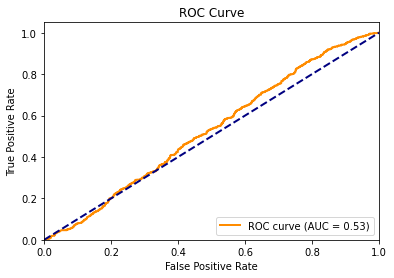

F1 Score: 0.7055467511885894
Accuracy: 0.5632346027268453
Running time: 0.009879112243652344 seconds
Testing time: 0.0006170272827148438 seconds


In [8]:
#Logistic Regression Model
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm

# Create feature by counting the number of website URLs visited in a day for each user
features = df.groupby(['panelist_id', 'gender_char', 'Date']).count().reset_index().groupby(['panelist_id', 'gender_char']).mean().reset_index().rename(columns={'PageUrl': 'website_count'})[['panelist_id', 'website_count', 'gender_char']]

# Map gender to 1 for female and 0 for male
features['gender_char'] = features['gender_char'].map({'female': 1, 'male': 0})

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features[['website_count']], features['gender_char'], test_size=0.2, random_state=42, shuffle=True)

# Train logistic regression model
start_time = time.time()
lr = LogisticRegression()
lr.fit(X_train, y_train)
end_time = time.time()

# Make predictions on test set
start_test_time = time.time()
y_pred = lr.predict(X_test)
end_test_time = time.time()

# Get probability estimates for the positive class
y_prob = lr.predict_proba(X_test)[:, 1]

# Calculate the FPR and TPR at different threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate F1 score
f1score = f1_score(y_test, y_pred)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("F1 Score:", f1score)
print("Accuracy:", accuracy)
print("Running time:", end_time - start_time, "seconds")
print("Testing time:", end_test_time - start_test_time, "seconds")



In [15]:
#Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, classification_report
import matplotlib.pyplot as plt
import time

# Group data by panelist_id and Date, and count the number of unique PageURLs for each user on each day
df_counts = df.groupby(['panelist_id', 'Date']).agg({'PageUrl': pd.Series.nunique}).reset_index()
df_counts = df_counts.rename(columns={'PageUrl': 'website_count'})

# Group data by panelist_id and gender_char, and count the number of unique days each user visits websites
df_days = df.groupby(['panelist_id', 'gender_char']).agg({'Date': pd.Series.nunique}).reset_index()
df_days = df_days.rename(columns={'Date': 'days_count'})

# Merge dataframes on panelist_id and gender_char
df_merged = pd.merge(df_counts, df_days, on='panelist_id')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_merged[['website_count', 'days_count']], df_merged['gender_char'], test_size=0.2, random_state=42,shuffle=True)

# Train decision tree classifier and measure running time
start_time = time.time()
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
end_time = time.time()
print("Model training time:", end_time - start_time, "seconds")

# Measure testing time
start_time = time.time()
y_pred = clf.predict(X_test)
end_time = time.time()
print("Model testing time:", end_time - start_time, "seconds")

# Get probability estimates for the positive class
y_prob = clf.predict_proba(X_test)[:, 1]


# Calculate F1 score
f1score = f1_score(y_test, y_pred, pos_label='female')

# Calculate classification report
report = classification_report(y_test, y_pred)

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("F1 Score:", f1score)
print("Model accuracy:", accuracy)
print(report)


Model training time: 0.2624318599700928 seconds
Model testing time: 0.0074748992919921875 seconds
F1 Score: 0.6816886007732261
Model accuracy: 0.5548415284629808
              precision    recall  f1-score   support

      female       0.56      0.87      0.68     30269
        male       0.51      0.17      0.26     24662

    accuracy                           0.55     54931
   macro avg       0.54      0.52      0.47     54931
weighted avg       0.54      0.55      0.49     54931



Model training time: 0.2683579921722412 seconds
Model testing time: 0.00947713851928711 seconds


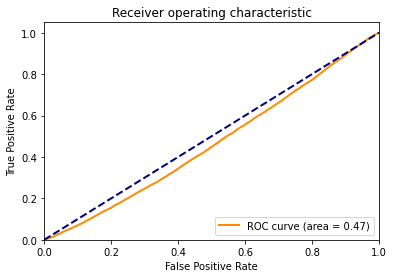

F1 Score: 0.6816625662253811
Model accuracy: 0.5548051191494784
              precision    recall  f1-score   support

      female       0.56      0.87      0.68     30269
        male       0.51      0.17      0.26     24662

    accuracy                           0.55     54931
   macro avg       0.54      0.52      0.47     54931
weighted avg       0.54      0.55      0.49     54931



In [17]:
#The main one with the roc
#Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, classification_report
import matplotlib.pyplot as plt
import time

# Group data by panelist_id and Date, and count the number of unique PageURLs for each user on each day
df_counts = df.groupby(['panelist_id', 'Date']).agg({'PageUrl': pd.Series.nunique}).reset_index()
df_counts = df_counts.rename(columns={'PageUrl': 'website_count'})

# Group data by panelist_id and gender_char, and count the number of unique days each user visits websites
df_days = df.groupby(['panelist_id', 'gender_char']).agg({'Date': pd.Series.nunique}).reset_index()
df_days = df_days.rename(columns={'Date': 'days_count'})

# Merge dataframes on panelist_id and gender_char
df_merged = pd.merge(df_counts, df_days, on='panelist_id')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_merged[['website_count', 'days_count']], df_merged['gender_char'], test_size=0.2, random_state=42,shuffle=True)

# Train decision tree classifier and measure running time
start_time = time.time()
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
end_time = time.time()
print("Model training time:", end_time - start_time, "seconds")

# Measure testing time
start_time = time.time()
y_pred = clf.predict(X_test)
end_time = time.time()
print("Model testing time:", end_time - start_time, "seconds")



# Calculate F1 score
f1score = f1_score(y_test, y_pred, pos_label='female')

# Calculate classification report
report = classification_report(y_test, y_pred)

# Get probability estimates for the positive class
y_prob = clf.predict_proba(X_test)[:, 1]

# Calculate FPR, TPR and thresholds for different threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='female')

# Calculate AUC score
roc_auc = auc(fpr, tpr)


# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("F1 Score:", f1score)
print("Model accuracy:", accuracy)
print(report)



